In [1]:
import os
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import movingpandas as mpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
# import torch

import scipy
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import scipy.stats

In [3]:
# Set the filename
# filename = '../data/SharkArray-2020-05-21-thru-05-28.csv'
# filename = '../data/2020-21-max-3-min-run.csv'
# filename = '../data/2020-13-141-long-5-min-run.csv'
filename = '../data/2020-21/2020-21-477-long-15-min-run.csv'
# filename = '../data/2020-20-05-21.csv'
# filename = '../data/2020-20-full.csv'

# Load shark positions data into a GeoDataFrame
shark_gdf = pd.read_csv(filename)
shark_gdf['t'] = pd.to_datetime(shark_gdf['DATETIME'])
shark_gdf['geometry'] = gpd.points_from_xy(shark_gdf.LON, shark_gdf.LAT)
shark_gdf = gpd.GeoDataFrame(shark_gdf)
shark_gdf = shark_gdf.set_crs('EPSG:4326')
shark_gdf = shark_gdf.set_index('t').tz_localize(None)
shark_gdf.head()

filename = os.path.splitext(os.path.basename(filename))[0]
# filename += '-v2'

In [4]:
output = '../graphs/{}'.format(filename)

In [5]:
print('The dataset contains', shark_gdf.shape[0], 'rows and', shark_gdf.shape[1], 'columns.')
print('The column names are:', list(shark_gdf.columns.values))
print('The unique transmitter names are:', shark_gdf['TRANSMITTER'].unique())

The dataset contains 493 rows and 17 columns.
The column names are: ['TRANSMITTER', 'DETECTEDID', 'DATETIME', 'X', 'Y', 'D', 'LAT', 'LON', 'n', 'HPE', 'HPEm', 'TEMP', 'DEPTH', 'ACCEL', 'DRX', 'URX', 'geometry']
The unique transmitter names are: ['2020-21']


In [6]:
# Create separate trajectories for each shark based on their transmitter ID
traj_collection = mpd.TrajectoryCollection(shark_gdf, 'TRANSMITTER')
traj = traj_collection.trajectories[0]
print(traj_collection, traj)

TrajectoryCollection with 1 trajectories Trajectory 2020-21 (2020-06-14 03:55:00 to 2020-06-14 18:47:00) | Size: 477 | Length: 22817.7m
Bounds: (-119.567408, 34.398575, -119.544495, 34.413013)
LINESTRING (-119.544495 34.399407, -119.544794 34.399889, -119.547951 34.401788, -119.548368 34.4018


In [7]:
# Add a timedelta column which is the time between the previous position and the current position
n = traj.df.shape[0]
timedeltas = [timedelta()] + [traj.df.index[i] - traj.df.index[i - 1] for i in range(1, n)]
traj.df['TIMEDELTA'] = timedeltas

In [8]:
# Add velocities and headings to each trajectory
traj.add_speed()
traj.add_direction()

In [9]:
# Compute turning angles
def bound_angle_diff(theta_diff):
    return ((theta_diff - 180) % 360) - 180

n = traj.df.shape[0]
turning_angles = [0] + [bound_angle_diff(traj.df['direction'][i + 1] - traj.df['direction'][i]) for i in range(1, n - 1)] + [0]
traj.df['turning_angle'] = turning_angles

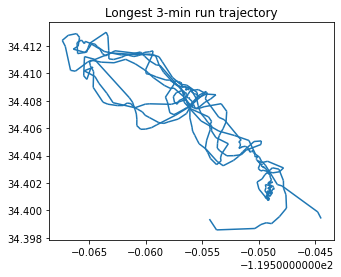

In [10]:
traj.plot(linestyle='None')
plt.title('Longest 3-min run trajectory')
plt.savefig('{}/{}-traj'.format(output, filename), bbox_inches="tight")

In [11]:
# Create a random generator
rng = np.random.default_rng()

[ 0.00000000e+00 -4.67762567e-01 -3.10683025e-02  7.30774878e-01
 -6.25230043e-02  3.44408715e-01 -4.68028916e-01  4.79307336e-01
 -1.98190997e-01 -1.50048266e-02  8.26868122e-02  6.31082577e-02
  9.62492841e-02 -1.96142417e-01 -4.61835916e-01 -6.79476233e-02
  4.54242941e-01  9.88913743e-02  3.59878921e-02 -5.10816268e-01
 -4.45757789e-02  1.78810640e-01  4.06561692e-01  1.41783571e+00
 -1.15310251e-02 -1.21400914e-01 -1.74204016e+00 -1.18283858e-01
 -8.18945626e-02  1.10593948e+00  5.56615982e-01  5.48041494e-01
  7.01644117e-01 -2.09068647e+00  7.96627894e-01  1.78895080e-01
 -2.94522791e-02  2.69802806e-01 -3.86409772e-01 -1.16280794e+00
  3.03424297e-01  1.07689952e-01  2.90127084e-02 -2.11840399e-01
  1.02981334e-02 -2.10328072e-01 -4.28491982e-02 -4.84091818e-01
  3.08920374e-01  8.01982519e-02 -1.08144881e-01 -8.00931196e-02
 -3.02837445e-01  8.23353713e-02 -2.19810531e-01  8.68356088e-01
 -2.02738617e-01 -2.66126504e-01  5.64949215e-01 -1.04649824e-01
 -4.62484829e-01  1.06904

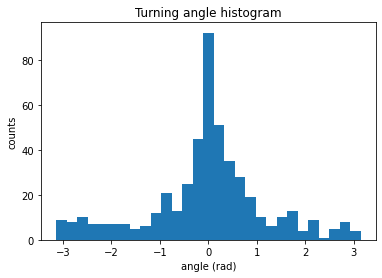

In [60]:
# Compute turning angles
def wrap_to_pi(theta):
    return ((theta - np.pi) % (2 * np.pi)) - np.pi

# turning_angles = wrap_to_pi(np.radians(np.array(traj.df['turning_angle'])))
turning_angles /= np.array([traj.df['TIMEDELTA'][1].total_seconds()] + [dt.total_seconds() for dt in traj.df['TIMEDELTA'][1:]])
turning_angles *= min(traj.df['TIMEDELTA'][1:]).total_seconds()
# turning_angles = tfd.VonMises(loc=-1, concentration=0).sample([207]).numpy()
print(turning_angles)
plt.hist(turning_angles, bins=np.linspace(-np.pi, np.pi, 30))
plt.title('Turning angle histogram')
plt.xlabel('angle (rad)')
plt.ylabel('counts')
plt.savefig('{}/{}-turning-angle-hist'.format(output, filename), bbox_inches="tight")

Text(0, 0.5, 'counts')

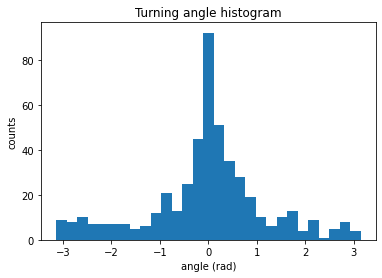

In [109]:
# pos_angles = [angle for angle in turning_angles if angle > 0]
# neg_angles = [angle for angle in turning_angles if angle <= 0]
# plt.hist(pos_angles, bins=np.linspace(-np.pi, np.pi, 30), alpha=0.8, label='positive angles')
# plt.hist(neg_angles, bins=np.linspace(-np.pi, np.pi, 30), alpha=0.8, label='negative angles')
plt.hist(turning_angles, bins=np.linspace(-np.pi, np.pi, 30))
plt.title('Turning angle histogram')
plt.xlabel('angle (rad)')
plt.ylabel('counts')
# plt.legend()

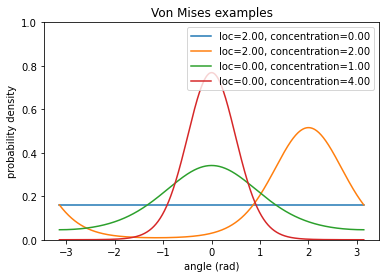

In [62]:
# Plot some example von Mises distributions
num = 1001
locs = [2, 2, 0, 0]
cons = [0, 2, 1, 4]
x = np.linspace(-np.pi, np.pi, num).reshape(num, 1)
y = tfd.VonMises(loc=locs, concentration=cons).prob(x).numpy()
for i in range(y.shape[1]):
    plt.plot(x[:, 0], y[:, i], label='loc={:.2f}, concentration={:.2f}'.format(locs[i], cons[i]))
plt.gca().set_ylim((0, 1))
plt.title('Von Mises examples')
plt.xlabel('angle (rad)')
plt.ylabel('probability density')
plt.legend()
plt.savefig('../animations/von-mises-examples', bbox_inches="tight")
plt.show()

In [63]:
# We assume 2 states
num_states = 2

# Randomly initialize the initial state distriubtion as well as the transition probabilities
initial_probs = tf.Variable(scipy.special.softmax(rng.random([num_states])), name='initial_probs')
transition_probs = tf.Variable(scipy.special.softmax(rng.random([num_states, num_states]), axis=1), name='transition_probs')

print("Initial state probs:\n{}".format(initial_probs))
print("Transition matrix:\n{}".format(transition_probs))

Initial state probs:
<tf.Variable 'initial_probs:0' shape=(2,) dtype=float64, numpy=array([0.46445204, 0.53554796])>
Transition matrix:
<tf.Variable 'transition_probs:0' shape=(2, 2) dtype=float64, numpy=
array([[0.34465234, 0.65534766],
       [0.48040276, 0.51959724]])>


In [64]:
# Initialize locations and concentrations of Von Mises distributions for turning angles
vm_locs = tf.Variable(np.zeros(num_states))
vm_cons = tf.Variable(np.zeros(num_states))

print('von Mises locations:\n{}'.format(vm_locs))
print('von Mises concentrations:\n{}'.format(vm_cons))

von Mises locations:
<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([0., 0.])>
von Mises concentrations:
<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([0., 0.])>


In [65]:
# Create HMM
hmm = tfd.HiddenMarkovModel(
    initial_distribution = tfd.Categorical(probs=initial_probs),
    transition_distribution = tfd.Categorical(probs=transition_probs),
    observation_distribution = tfd.VonMises(loc=vm_locs, concentration=vm_cons),
    num_steps = len(turning_angles)
)

In [66]:
# Define a loss function
def log_prob():
    return tf.reduce_logsumexp(hmm.log_prob(turning_angles))

# Define an optimizer to perform back propagation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Make sure probabilities sum to 1
def normalize_probs(probs):
    abs_probs = tf.math.abs(probs)
    if len(probs.shape) > 1:
        sums = tf.reshape(tf.reduce_sum(abs_probs, axis=1), [probs.shape[0], 1])
    else:
        sums = tf.reduce_sum(abs_probs)
    return abs_probs / sums

def wrap_to_pi(A):
    return ((A - np.pi) % (2 * np.pi) - np.pi)

# Run a step of the optimizer
@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    vars = [initial_probs, transition_probs, vm_locs, vm_cons]
    grads = tape.gradient(neg_log_prob, vars)
    optimizer.apply_gradients(zip(grads, vars))
    initial_probs.assign(normalize_probs(initial_probs))
    transition_probs.assign(normalize_probs(transition_probs))
    vm_locs.assign(wrap_to_pi(vm_locs))
    vm_cons.assign(tf.math.abs(vm_cons))
    return neg_log_prob, *vars

In [67]:
# Train on the observations
loss_history = []
for step in range(201):
    loss, ip, tp, vl, vc = [t.numpy() for t in train_op()]
    loss_history.append(loss)
    if step % 20 == 0:
        print("step {}: log prob {}\nInitial probs: {}\nTransition probs:\n{}\nVon Mises locs: {}\nVon Mises cons: {}\n".format(step, -loss, ip, tp, vl, vc))

step 0: log prob -876.6673606772515
Initial probs: [0.46445204 0.53554796]
Transition probs:
[[0.34465229 0.65534771]
 [0.48040279 0.51959721]]
Von Mises locs: [0. 0.]
Von Mises cons: [0.1 0.1]

step 20: log prob -734.7805976448567
Initial probs: [0.94758115 0.05241885]
Transition probs:
[[0.95372238 0.04627762]
 [0.98069105 0.01930895]]
Von Mises locs: [ 0.04301549 -0.01343149]
Von Mises cons: [1.48052325 1.03797313]

step 40: log prob -686.971446427029
Initial probs: [0.9329002 0.0670998]
Transition probs:
[[0.95281137 0.04718863]
 [0.06803071 0.93196929]]
Von Mises locs: [ 0.03008588 -0.05744957]
Von Mises cons: [1.87106582 0.89605555]

step 60: log prob -628.0844136301062
Initial probs: [0.9302769 0.0697231]
Transition probs:
[[0.92835726 0.07164274]
 [0.03741264 0.96258736]]
Von Mises locs: [0.03632182 0.6264226 ]
Von Mises cons: [2.97000889 0.01536302]

step 80: log prob -618.0141210841167
Initial probs: [0.93639501 0.06360499]
Transition probs:
[[0.94114068 0.05885932]
 [0.02687

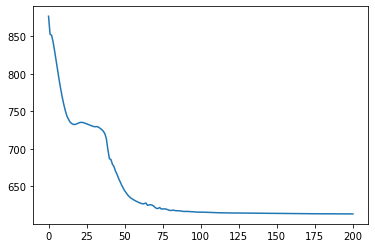

In [68]:
plt.plot(loss_history)
plt.savefig('{}/{}-univariate-loss-hist'.format(output, filename), bbox_inches="tight")

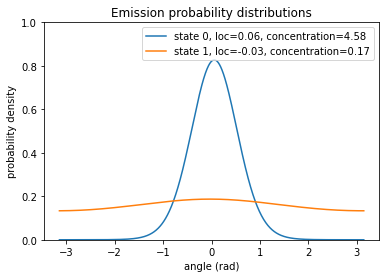

In [69]:
# Plot von Mises distributions
num = 1001
x = np.linspace(-np.pi, np.pi, num).reshape(num, 1)
y = hmm.observation_distribution.prob(x).numpy()
for i in range(y.shape[1]):
    plt.plot(x[:, 0], y[:, i], label='state {}, loc={:.2f}, concentration={:.2f}'.format(i, vm_locs[i], vm_cons[i]))
plt.gca().set_ylim((0, 1))
plt.title('Emission probability distributions')
plt.xlabel('angle (rad)')
plt.ylabel('probability density')
plt.legend()
plt.savefig('{}/{}-univariate-emission-dists'.format(output, filename), bbox_inches="tight")
plt.show()

In [70]:
posterior_dists = hmm.posterior_marginals(turning_angles)
posterior_probs = posterior_dists.probs_parameter().numpy()

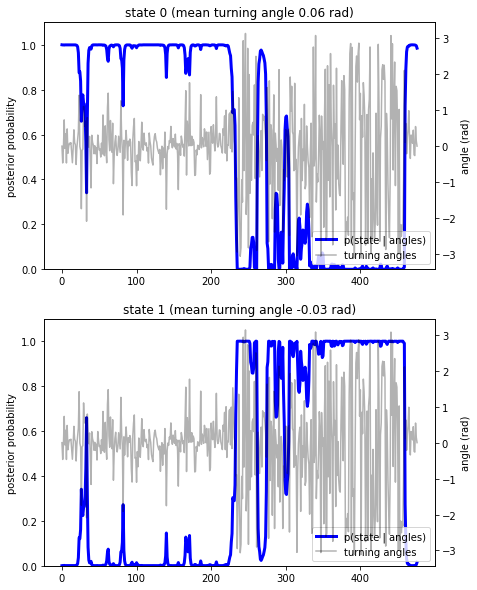

In [71]:
def plot_state_posterior(ax, state_posterior_probs, observed_data, title, label='turning angles', ylabel='angle (rad)'):
    ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | angles)')
    ax.set_ylim(0., 1.1)
    ax.set_ylabel('posterior probability')
    ax2 = ax.twinx()
    ln2 = ax2.plot(observed_data, c='black', alpha=0.3, label=label)
    ax2.set_title(title)
    ax2.set_ylabel(ylabel)
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color='white')
    ax2.grid(False)

fig, axs = plt.subplots(num_states, 1, figsize=(7, 5 * num_states))
for state in range(num_states):
    plot_state_posterior(axs[state], posterior_probs[:, state], turning_angles, 'state {} (mean turning angle {:.2f} rad)'.format(state, vm_locs[state]))

plt.savefig('{}/{}-univariate-obs-posterior-probs'.format(output, filename), bbox_inches="tight")

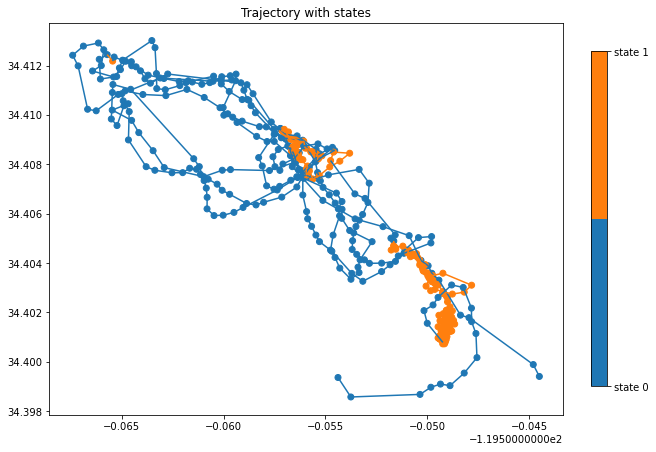

In [72]:
x = [point.coords[0][0] for point in traj.df['geometry']]
y = [point.coords[0][1] for point in traj.df['geometry']]
fig, ax = plt.subplots(figsize=(10, 10))
cmaplist = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'][:num_states]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, num_states)
color = np.argmax(posterior_probs, axis=1)
sc = ax.scatter(x, y, c=color, cmap=cmap)
traj.df['state'] = color
traj.plot(ax=ax, marker='o', column='state', cmap=cmap)
ticks = np.array(list(range(num_states)))
tick_labels = ['state {}'.format(i) for i in range(num_states)]
cbar = plt.colorbar(sc, fraction=0.03)
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
plt.title('Trajectory with states')
plt.savefig('{}/{}-univariate-obs-traj-with-states'.format(output, filename), bbox_inches="tight")

In [73]:
np.sum(np.argmax(posterior_probs, axis=1))

210

In [74]:
# Save to csv with states
traj.df.to_csv('../data/{}-{}-states.csv'.format(filename, num_states), index=False)

[1.00203979 1.00203979 0.54342881 0.66627952 0.77062007 0.73826385
 0.62909517 0.67213003 0.51384208 0.52002509 0.72621811 0.55872034
 0.48788886 0.81690047 0.74208415 0.41675071 0.50220446 0.57455576
 0.82148945 0.41014391 0.42699696 0.50904473 1.13923727 0.64611898
 0.37477466 0.64807777 0.58134151 0.52972863 0.62781835 0.67137309
 0.4137006  0.74082056 0.34659153 0.63503443 0.16245884 0.74475552
 0.73658562 0.37959561 0.68897183 0.52509354 0.73643926 0.55475181
 0.60036439 0.72945177 0.55414935 0.62215609 0.42797465 0.57243321
 0.54035114 0.46960945 0.81841325 0.66176645 0.52151902 0.73109858
 0.76290138 0.69190718 0.22690241 0.54335207 0.62759611 0.54434351
 0.574058   0.41055196 0.78694997 0.59105667 0.87781197 0.64195972
 0.5698904  0.50772603 0.53359373 0.61545512 0.37873425 0.53846476
 0.74348834 0.40258066 0.65219352 0.3461703  0.51512771 0.68263195
 0.76795138 0.6831707  0.28768185 0.55368334 0.50032122 0.45392826
 0.64474867 0.33431485 0.61179541 0.73998823 0.31680001 0.3421

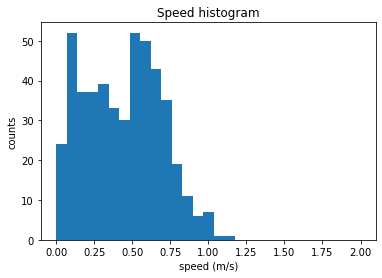

In [75]:
speeds = np.array(traj.df['speed'])
print(speeds, len(speeds))
plt.hist(speeds, bins=np.linspace(0, np.ceil(np.max(speeds)), 30))
plt.title('Speed histogram')
plt.xlabel('speed (m/s)')
plt.ylabel('counts')
plt.savefig('{}/{}-speed-hist'.format(output, filename), bbox_inches="tight")

In [76]:
# We assume 2 states
num_states = 2

# Randomly initialize the initial state distriubtion as well as the transition probabilities
initial_probs = tf.Variable(scipy.special.softmax(rng.random([num_states])), name='initial_probs')
transition_probs = tf.Variable(scipy.special.softmax(rng.random([num_states, num_states]), axis=1), name='transition_probs')

print("Initial state probs:\n{}".format(initial_probs))
print("Transition matrix:\n{}".format(transition_probs))

Initial state probs:
<tf.Variable 'initial_probs:0' shape=(2,) dtype=float64, numpy=array([0.59631255, 0.40368745])>
Transition matrix:
<tf.Variable 'transition_probs:0' shape=(2, 2) dtype=float64, numpy=
array([[0.3585354 , 0.6414646 ],
       [0.54273978, 0.45726022]])>


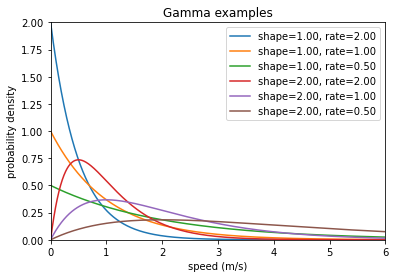

In [77]:
# Plot some example gamma distributions
num = 1001
shapes = [1, 1, 1, 2, 2, 2]
rates = [2, 1, 0.5, 2, 1, 0.5]
x = np.linspace(0, 6, num).reshape(num, 1)
y = tfd.Gamma(concentration=shapes, rate=rates).prob(x).numpy()
for i in range(y.shape[1]):
    plt.plot(x[:, 0], y[:, i], label='shape={:.2f}, rate={:.2f}'.format(shapes[i], rates[i]))
plt.gca().set_xlim((0, 6))
plt.gca().set_ylim((0, np.max(y)))
plt.title('Gamma examples')
plt.xlabel('speed (m/s)')
plt.ylabel('probability density')
plt.legend()
plt.savefig('../animations/gamma-examples', bbox_inches="tight")
plt.show()

In [78]:
# Initialize locations and concentrations of Von Mises distributions for turning angles
vm_locs = tf.Variable(np.zeros(num_states))
vm_cons = tf.Variable(np.zeros(num_states))
# vm_locs = tf.Variable(rng.random(num_states))
# vm_cons = tf.Variable(rng.random(num_states))

# Initialize shapes and rates of Gamma distributions for step length
gamma_shapes = tf.Variable(np.ones(num_states))
gamma_rates = tf.Variable(np.ones(num_states))
# gamma_shapes = tf.Variable(rng.random(num_states))
# gamma_rates = tf.Variable(rng.random(num_states))

# joint_dists = tfd.JointDistributionSequential([
#     tfd.VonMises(loc=vm_locs, concentration=vm_cons),
#     tfd.Gamma(concentration=gamma_shapes, rate=gamma_rates)
# ])

joint_dists = tfd.Blockwise([
    tfd.VonMises(loc=vm_locs, concentration=vm_cons),
    tfd.Gamma(concentration=gamma_shapes, rate=gamma_rates)
])

print('von Mises locations:\n{}'.format(vm_locs))
print('von Mises concentrations:\n{}'.format(vm_cons))
print('Gamma shapes:\n{}'.format(gamma_shapes))
print('Gamma rates:\n{}'.format(gamma_rates))
print(joint_dists)

von Mises locations:
<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([0., 0.])>
von Mises concentrations:
<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([0., 0.])>
Gamma shapes:
<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([1., 1.])>
Gamma rates:
<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([1., 1.])>
tfp.distributions.Blockwise("Blockwise", batch_shape=[2], event_shape=[2], dtype=float64)


In [79]:
# Create HMM
hmm2 = tfd.HiddenMarkovModel(
    initial_distribution = tfd.Categorical(probs=initial_probs),
    transition_distribution = tfd.Categorical(probs=transition_probs),
    observation_distribution = joint_dists,
    num_steps = len(turning_angles)
)

In [80]:
hmm2.log_prob(np.array([turning_angles, speeds]).T)

<tf.Tensor: shape=(), dtype=float64, numpy=-1085.5263964172982>

In [81]:
# Define a loss function
def log_prob():
    return tf.reduce_logsumexp(hmm2.log_prob(np.array([turning_angles, speeds]).T))

# Define an optimizer to perform back propagation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Make sure probabilities sum to 1
def normalize_probs(probs):
    abs_probs = tf.math.abs(probs)
    if len(probs.shape) > 1:
        sums = tf.reshape(tf.reduce_sum(abs_probs, axis=1), [probs.shape[0], 1])
    else:
        sums = tf.reduce_sum(abs_probs)
    return abs_probs / sums

def wrap_to_pi(A):
    return ((A - np.pi) % (2 * np.pi) - np.pi)

# Run a step of the optimizer
@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    vars = [initial_probs, transition_probs, vm_locs, vm_cons, gamma_shapes, gamma_rates]
    grads = tape.gradient(neg_log_prob, vars)
    optimizer.apply_gradients(zip(grads, vars))
    initial_probs.assign(normalize_probs(initial_probs))
    transition_probs.assign(normalize_probs(transition_probs))
    vm_locs.assign(wrap_to_pi(vm_locs))
    vm_cons.assign(tf.math.abs(vm_cons))
    gamma_shapes.assign(tf.math.abs(gamma_shapes))
    gamma_rates.assign(tf.math.abs(gamma_rates))
    return (neg_log_prob, *vars), grads

In [82]:
# Train on the observations
loss_history = []
for step in range(1000):
    ts, grads = train_op()
    loss, ip, tp, vl, vc, gs, gr = [t.numpy() for t in ts]
    loss_history.append(loss)
    if step % 100 == 0:
        print("step {}: log prob {}\nInitial probs: {}\nTransition probs:\n{}\nVon Mises locs: {}\nVon Mises cons: {}\nGamma shapes: {}\nGamma rates: {}\n".format(step, -loss, ip, tp, vl, vc, gs, gr))

step 0: log prob -1085.5263964172982
Initial probs: [0.59631255 0.40368745]
Transition probs:
[[0.35853532 0.64146468]
 [0.54273984 0.45726016]]
Von Mises locs: [0. 0.]
Von Mises cons: [0.1 0.1]
Gamma shapes: [1.1 1.1]
Gamma rates: [1.1 1.1]

step 100: log prob -479.0524831378651
Initial probs: [0.94568833 0.05431167]
Transition probs:
[[0.94624615 0.05375385]
 [0.05476867 0.94523133]]
Von Mises locs: [0.04226921 0.19470463]
Von Mises cons: [3.95694811 0.11681045]
Gamma shapes: [3.85286082 1.25808145]
Gamma rates: [6.01463136 5.10481878]

step 200: log prob -430.58490399572537
Initial probs: [0.94940525 0.05059475]
Transition probs:
[[0.95016684 0.04983316]
 [0.04885083 0.95114917]]
Von Mises locs: [0.04121966 0.1967183 ]
Von Mises cons: [4.0428019  0.13247498]
Gamma shapes: [5.66100453 1.61109681]
Gamma rates: [9.0326326  7.27339412]

step 300: log prob -411.15998169935983
Initial probs: [0.95054493 0.04945507]
Transition probs:
[[0.95137966 0.04862034]
 [0.04753295 0.95246705]]
Von M

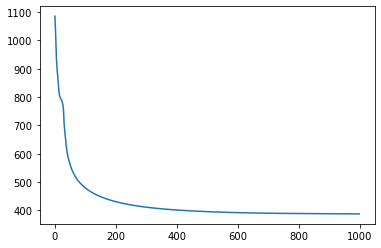

In [83]:
plt.plot(loss_history)
plt.savefig('{}/{}-bivariate-loss-hist'.format(output, filename), bbox_inches="tight")

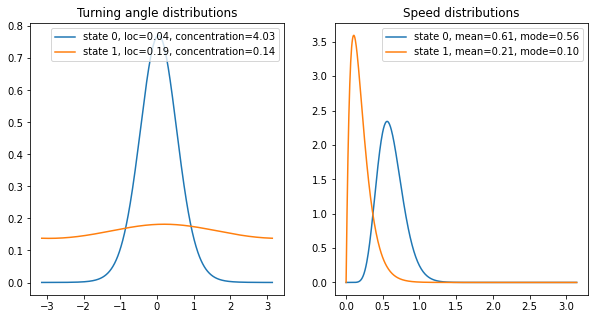

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot observation distributions
num = 1001
x = np.linspace(-np.pi, np.pi, num).reshape(num, 1)
for (j, (obs_dist, ax)) in enumerate(zip(hmm2.observation_distribution.distributions, axs)):
    y = obs_dist.prob(x).numpy()
    for i in range(y.shape[1]):
        if j == 0:
            label = 'state {}, loc={:.2f}, concentration={:.2f}'.format(i, vm_locs[i], vm_cons[i])
            title = 'Turning angle distributions'
        else:
            label = 'state {}, mean={:.2f}, mode={:.2f}'.format(i, gamma_shapes[i] / gamma_rates[i], (gamma_shapes[i] - 1) / gamma_rates[i])
            title = 'Speed distributions'
        ax.plot(x[:, 0], y[:, i], label=label)
        ax.set_title(title)
        ax.legend(loc='upper right')
plt.savefig('{}/{}-bivariate-emission-dists'.format(output, filename), bbox_inches="tight")
plt.show()

In [85]:
posterior_dists = hmm2.posterior_marginals(np.array([turning_angles, speeds]).T)
posterior_probs = posterior_dists.probs_parameter().numpy()

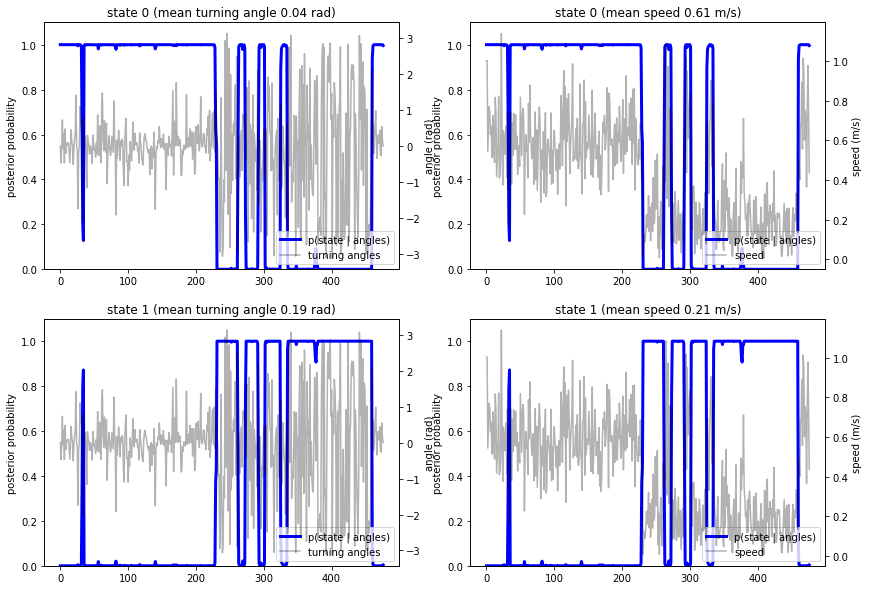

In [86]:
fig, axs = plt.subplots(num_states, 2, figsize=(14, 5 * num_states))
for state, ax_row in enumerate(axs):
    for i, ax in enumerate(ax_row):
        if i == 0:
            plot_state_posterior(ax, posterior_probs[:, state], turning_angles, 'state {} (mean turning angle {:.2f} rad)'.format(state, vm_locs[state]))
        else:
            plot_state_posterior(ax, posterior_probs[:, state], speeds, 'state {} (mean speed {:.2f} m/s)'.format(state, gamma_shapes[state] / gamma_rates[state]), label='speed', ylabel='speed (m/s)')
#         ax.set_xlim((0, 100))
plt.savefig('{}/{}-bivariate-obs-posterior-probs'.format(output, filename), bbox_inches="tight")    

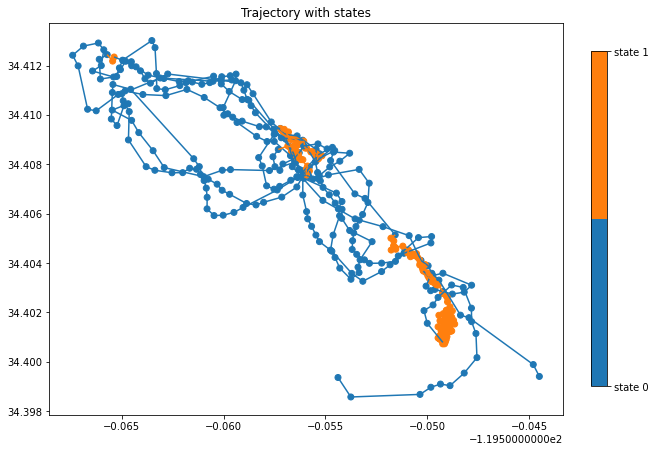

In [87]:
x = [point.coords[0][0] for point in traj.df['geometry']]
y = [point.coords[0][1] for point in traj.df['geometry']]
fig, ax = plt.subplots(figsize=(10, 10))
cmaplist = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'][:num_states]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, num_states)
color = np.argmax(posterior_probs, axis=1)
sc = ax.scatter(x, y, c=color, cmap=cmap)
traj.df['state'] = color
traj.plot(ax=ax, marker='o', column='state', cmap=cmap)
ticks = np.array(list(range(num_states)))
tick_labels = ['state {}'.format(i) for i in range(num_states)]
cbar = plt.colorbar(sc, fraction=0.03)
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
plt.title('Trajectory with states')
plt.savefig('{}/{}-bivariate-obs-traj-with-states'.format(output, filename), bbox_inches="tight")

In [88]:
# Save to csv with states
traj.df.to_csv('../data/{}-{}-states-with-speeds.csv'.format(filename, num_states), index=False)

In [89]:
def get_sample_traj(sampled_obs, traj):
    '''
    Converts a sample from an HMM to a trajectory
    '''
    # Bound angles to [-pi, pi]
    def wrap_to_pi(theta):
        return ((theta - 180) % 360) - 180
    
    # Convert sampled observations to x and y positions
    sampled_x = [0]
    sampled_y = [0]
    sampled_angle = [0]
    sampled_turning_angle = [sampled_obs[0][0]]
    sampled_speed = [sampled_obs[1][0]]
    times = np.array([dt.total_seconds() for dt in traj.df['TIMEDELTA']])
    for i, (dt, (turning_angle, speed)) in enumerate(zip(times, sampled_obs)):
        prev_x = sampled_x[i]
        prev_y = sampled_y[i]
        prev_angle = sampled_angle[i]
        step_length = dt * speed
        angle = wrap_to_pi(prev_angle + turning_angle)
        x = step_length * np.cos(angle) + prev_x
        y = step_length * np.sin(angle) + prev_y
        sampled_x.append(x)
        sampled_y.append(y)
        sampled_angle.append(angle)
        sampled_turning_angle.append(turning_angle)
        sampled_speed.append(speed)
    
    # Align the samples' centroids and make them the same scale
    sampled_x = np.array(sampled_x)
    sampled_y = np.array(sampled_y)
    avg_x = np.average(sampled_x)
    avg_y = np.average(sampled_y)
    sampled_x -= avg_x
    sampled_y -= avg_y
    actual_x = []
    actual_y = []
    for point in traj.df['geometry']:
        x, y = point.coords[0]
        actual_x.append(x)
        actual_y.append(y)
    actual_x = np.array(actual_x)
    actual_y = np.array(actual_y)
    avg_x = np.average(actual_x)
    avg_y = np.average(actual_y)
    actual_range_x = np.max(actual_x) - np.min(actual_x)
    actual_range_y = np.max(actual_y) - np.min(actual_y)
    sampled_range_x = np.max(sampled_x) - np.min(sampled_x)
    sampled_range_y = np.max(sampled_y) - np.min(sampled_y)
    sampled_x *= actual_range_x / sampled_range_x
    sampled_y *= actual_range_y / sampled_range_y
    sampled_x += avg_x
    sampled_y += avg_y
    data = np.array([sampled_x, sampled_y, sampled_angle, sampled_turning_angle, sampled_speed])
    sample_traj = pd.DataFrame(data.T[1:], columns=['LON', 'LAT', 'direction', 'turning_angle', 'speed'])
    sample_traj['t'] = traj.df.index
    sample_traj['geometry'] = gpd.points_from_xy(sample_traj.LON, sample_traj.LAT)
    sample_traj = gpd.GeoDataFrame(sample_traj)
    sample_traj = sample_traj.set_crs('EPSG:4326')
    sample_traj = sample_traj.set_index('t').tz_localize(None)
    return mpd.Trajectory(sample_traj, traj.id + '-sampled')

In [90]:
# Sample the HMM to get a path
sampled_obs = hmm2.sample().numpy()
sample_traj = get_sample_traj(sampled_obs, traj)

In [91]:
print(sample_traj)
print(traj)

Trajectory 2020-21-sampled (2020-06-14 03:55:00 to 2020-06-14 18:47:00) | Size: 477 | Length: 11888.2m
Bounds: (-119.56414567217129, 34.400723896038336, -119.54123267217129, 34.415161896038335)
LINESTRING (-119.5455835045259 34.41516189603833, -119.5455180011766 34.41499122577656, -119.5426117
Trajectory 2020-21 (2020-06-14 03:55:00 to 2020-06-14 18:47:00) | Size: 477 | Length: 22817.7m
Bounds: (-119.567408, 34.398575, -119.544495, 34.413013)
LINESTRING (-119.544495 34.399407, -119.544794 34.399889, -119.547951 34.401788, -119.548368 34.4018


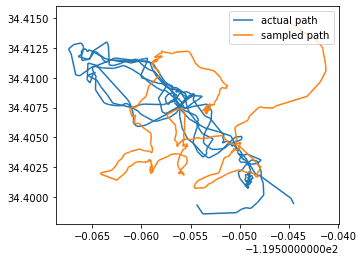

In [92]:
fig, ax = plt.subplots()
traj.plot(ax=ax, label='actual path', color='#1f77b4')
sample_traj.plot(ax=ax, label='sampled path', color='#ff7f0e')
plt.legend()
plt.savefig('{}/{}-sampled-traj'.format(output, filename), bbox_inches="tight")

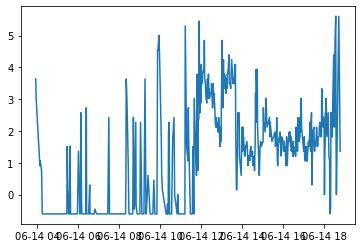

In [93]:
plt.plot(traj.df['DEPTH'])

In [94]:
observations = []
num_missing = 0
for idx, row in traj.df.iterrows():
    # Append missing observations for minutes without an observation
    for i in range(max(int(row['TIMEDELTA'].total_seconds() / 60) - 1, 0)):
        num_missing += 1
        observations.append([1, 1.0, 1.0])
    observations.append([0, np.radians(row['turning_angle']), row['speed']])
observations = np.array(observations)
p_missing = tf.constant(num_missing / len(observations), dtype=tf.float32)
print(p_missing, num_missing, len(observations))

tf.Tensor(0.46584547, shape=(), dtype=float32) 416 893


In [95]:
# We assume 2 states
num_states = 2

# Randomly initialize the initial state distribution as well as the transition probabilities
initial_probs = tf.Variable(scipy.special.softmax(rng.random([num_states])), name='initial_probs', dtype=tf.float32)
transition_probs = tf.Variable(scipy.special.softmax(rng.random([num_states, num_states]), axis=1), name='transition_probs', dtype=tf.float32)

print("Initial state probs:\n{}".format(initial_probs))
print("Transition matrix:\n{}".format(transition_probs))

Initial state probs:
<tf.Variable 'initial_probs:0' shape=(2,) dtype=float32, numpy=array([0.49628207, 0.5037179 ], dtype=float32)>
Transition matrix:
<tf.Variable 'transition_probs:0' shape=(2, 2) dtype=float32, numpy=
array([[0.5052936 , 0.4947064 ],
       [0.5139743 , 0.48602572]], dtype=float32)>


In [96]:
# Initialize locations and concentrations of Von Mises distributions for turning angles
vm_locs = tf.Variable(np.zeros(num_states), dtype=tf.float32)
vm_cons = tf.Variable(np.zeros(num_states), dtype=tf.float32)
# vm_locs = tf.Variable(rng.random(num_states))
# vm_cons = tf.Variable(rng.random(num_states))

# Initialize shapes and rates of Gamma distributions for step length
gamma_shapes = tf.Variable(np.ones(num_states), dtype=tf.float32)
gamma_rates = tf.Variable(np.ones(num_states), dtype=tf.float32)
# gamma_shapes = tf.Variable(rng.random(num_states))
# gamma_rates = tf.Variable(rng.random(num_states))

mixed_dists = tfd.Mixture(
    cat=tfd.Categorical(probs=[[1 - p_missing, p_missing]] * num_states),
    components=[
        tfd.Blockwise([
            tfd.Categorical(probs=[[1.0, 0.0]] * num_states),
            tfd.VonMises(loc=vm_locs, concentration=vm_cons),
            tfd.Gamma(concentration=gamma_shapes, rate=gamma_rates)
        ], dtype_override=tf.float32),
        tfd.Independent(
            tfd.Deterministic(loc=tf.zeros([num_states, 3]) + 1),
            reinterpreted_batch_ndims=1)
    ]
)

print('von Mises locations:\n{}'.format(vm_locs))
print('von Mises concentrations:\n{}'.format(vm_cons))
print('Gamma shapes:\n{}'.format(gamma_shapes))
print('Gamma rates:\n{}'.format(gamma_rates))
print(mixed_dists)

von Mises locations:
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>
von Mises concentrations:
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>
Gamma shapes:
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>
Gamma rates:
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>
tfp.distributions.Mixture("Mixture", batch_shape=[2], event_shape=[3], dtype=float32)


In [97]:
# Create HMM
hmm3 = tfd.HiddenMarkovModel(
    initial_distribution = tfd.Categorical(probs=initial_probs),
    transition_distribution = tfd.Categorical(probs=transition_probs),
    observation_distribution = mixed_dists,
    num_steps = len(observations)
)

In [98]:
# Define a loss function
def log_prob():
    return hmm3.log_prob(observations)

# Define an optimizer to perform back propagation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Make sure probabilities sum to 1
def normalize_probs(probs):
    abs_probs = tf.math.abs(probs)
    if len(probs.shape) > 1:
        sums = tf.reshape(tf.reduce_sum(abs_probs, axis=1), [probs.shape[0], 1])
    else:
        sums = tf.reduce_sum(abs_probs)
    return abs_probs / sums

def wrap_to_pi(A):
    return ((A - np.pi) % (2 * np.pi) - np.pi)

# Run a step of the optimizer
@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    vars = [initial_probs, transition_probs, vm_locs, vm_cons, gamma_shapes, gamma_rates]
    grads = tape.gradient(neg_log_prob, vars)
    optimizer.apply_gradients(zip(grads, vars))
    initial_probs.assign(normalize_probs(initial_probs))
    transition_probs.assign(normalize_probs(transition_probs))
    vm_locs.assign(wrap_to_pi(vm_locs))
    vm_cons.assign(tf.math.abs(vm_cons))
    gamma_shapes.assign(tf.math.abs(gamma_shapes))
    gamma_rates.assign(tf.math.abs(gamma_rates))
    return (neg_log_prob, *vars), grads

In [99]:
hmm3.log_prob(observations)

<tf.Tensor: shape=(), dtype=float32, numpy=-1702.4266>

In [100]:
# Train on the observations
loss_history = []
for step in range(500):
    ts, grads = train_op()
    loss, ip, tp, vl, vc, gs, gr = [t.numpy() for t in ts]
    loss_history.append(loss)
    if step % 50 == 0:
        print("step {}: log prob {}\nInitial probs: {}\nTransition probs:\n{}\nVon Mises locs: {}\nVon Mises cons: {}\nGamma shapes: {}\nGamma rates: {}\n".format(step, -loss, ip, tp, vl, vc, gs, gr))

step 0: log prob -1702.4266357421875
Initial probs: [0.5020535 0.4979464]
Transition probs:
[[0.4054948  0.59450513]
 [0.41408658 0.58591336]]
Von Mises locs: [0. 0.]
Von Mises cons: [0.10000001 0.1       ]
Gamma shapes: [1.1 1.1]
Gamma rates: [1.1 1.1]

step 50: log prob -1252.978515625
Initial probs: [0.05887751 0.94112253]
Transition probs:
[[0.93343645 0.06656354]
 [0.06166256 0.93833745]]
Von Mises locs: [2.9847882  0.04136944]
Von Mises cons: [0.42198783 2.5083647 ]
Gamma shapes: [1.012125 2.634098]
Gamma rates: [3.4973667 3.7599936]

step 100: log prob -1185.615234375
Initial probs: [0.05311083 0.94688916]
Transition probs:
[[0.94415545 0.05584452]
 [0.05458009 0.9454199 ]]
Von Mises locs: [2.809992   0.04093146]
Von Mises cons: [0.3999659 2.9511917]
Gamma shapes: [1.3720565 3.688618 ]
Gamma rates: [5.516258  5.6670885]

step 150: log prob -1156.559326171875
Initial probs: [0.05106546 0.9489345 ]
Transition probs:
[[0.94692516 0.05307484]
 [0.0536596  0.94634044]]
Von Mises locs

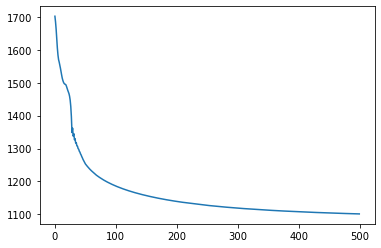

In [101]:
plt.savefig('{}/{}-missing-obs-loss-hist'.format(output, filename), bbox_inches="tight")
plt.plot(loss_history)

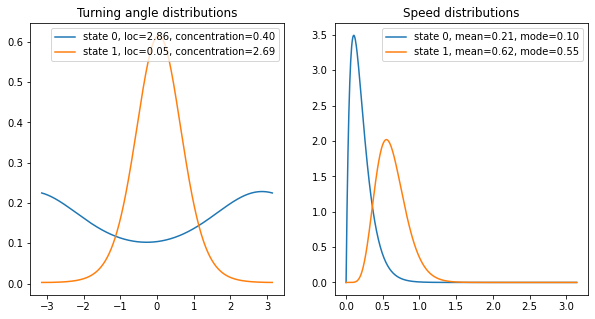

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot observation distributions
num = 1001
x = np.linspace(-np.pi, np.pi, num).reshape(num, 1)
for (j, (obs_dist, ax)) in enumerate(zip([tfd.VonMises(loc=vm_locs, concentration=vm_cons), tfd.Gamma(concentration=gamma_shapes, rate=gamma_rates)], axs)):
    y = obs_dist.prob(x).numpy()
    for i in range(y.shape[1]):
        if j == 0:
            label = 'state {}, loc={:.2f}, concentration={:.2f}'.format(i, vm_locs[i], vm_cons[i])
            title = 'Turning angle distributions'
        else:
            label = 'state {}, mean={:.2f}, mode={:.2f}'.format(i, gamma_shapes[i] / gamma_rates[i], (gamma_shapes[i] - 1) / gamma_rates[i])
            title = 'Speed distributions'
        ax.plot(x[:, 0], y[:, i], label=label)
        ax.set_title(title)
        ax.legend(loc='upper right')
plt.savefig('{}/{}-missing-obs-emission-dists'.format(output, filename), bbox_inches="tight")
plt.show()

In [103]:
posterior_dists = hmm3.posterior_marginals(tf.constant(observations, dtype=tf.float32))
posterior_probs = posterior_dists.probs_parameter().numpy()

In [104]:
hmm2_posterior_mode = hmm2.posterior_mode(np.array([turning_angles, speeds]).T)
hmm3_posterior_mode = hmm3.posterior_mode(tf.constant(observations, dtype=tf.float32))

In [105]:
hmm3_posterior_mode_matched = []
posterior_probs_matched = []
for state, probs, obs in zip(hmm3_posterior_mode, posterior_probs, observations):
    if obs[0] == 0:
        hmm3_posterior_mode_matched.append(state)
        posterior_probs_matched.append(probs)
hmm3_posterior_mode_matched = np.array(hmm3_posterior_mode_matched)
posterior_probs_matched = np.array(posterior_probs_matched)

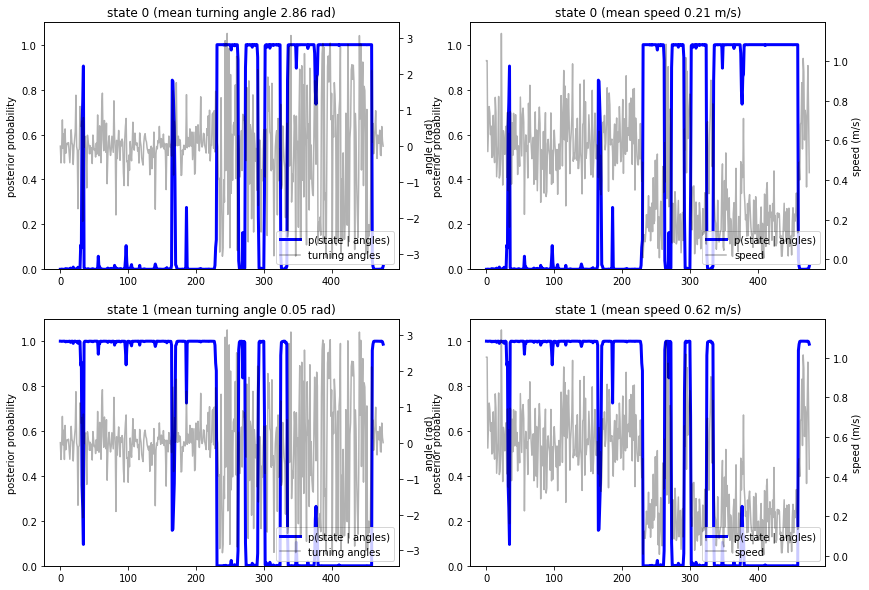

In [106]:
fig, axs = plt.subplots(num_states, 2, figsize=(14, 5 * num_states))
for state, ax_row in enumerate(axs):
    for i, ax in enumerate(ax_row):
        if i == 0:
            plot_state_posterior(ax, posterior_probs_matched[:, state], turning_angles, 'state {} (mean turning angle {:.2f} rad)'.format(state, vm_locs[state]))
        else:
            plot_state_posterior(ax, posterior_probs_matched[:, state], speeds, 'state {} (mean speed {:.2f} m/s)'.format(state, gamma_shapes[state] / gamma_rates[state]), label='speed', ylabel='speed (m/s)')
plt.savefig('{}/{}-missing-obs-posterior-probs'.format(output, filename), bbox_inches="tight")

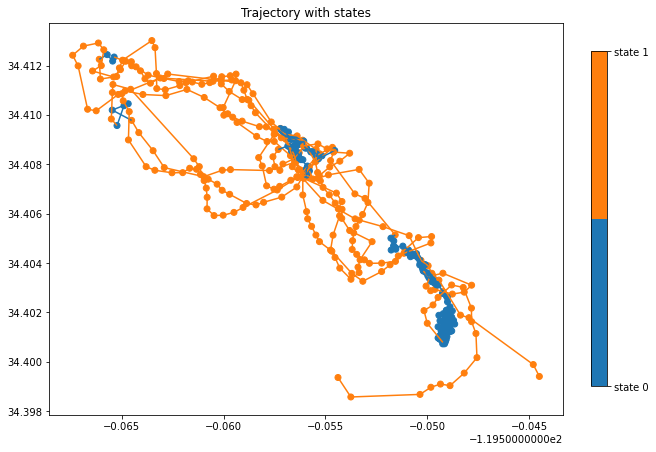

In [107]:
x = [point.coords[0][0] for point in traj.df['geometry']]
y = [point.coords[0][1] for point in traj.df['geometry']]
fig, ax = plt.subplots(figsize=(10, 10))
cmaplist = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'][:num_states]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, num_states)
color = np.argmax(posterior_probs_matched, axis=1)
sc = ax.scatter(x, y, c=color, cmap=cmap)
traj.df['state'] = color
traj.plot(ax=ax, marker='o', column='state', cmap=cmap)
ticks = np.array(list(range(num_states)))
tick_labels = ['state {}'.format(i) for i in range(num_states)]
cbar = plt.colorbar(sc, fraction=0.03)
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
plt.title('Trajectory with states')
plt.savefig('{}/{}-missing-obs-traj-with-states'.format(output, filename), bbox_inches="tight")